# Download Daymet

Daymet provides gridded meteorological data for North American at 1km spatial resolution with daily timestep from 1980 ~ present. [website](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1328) and [user guide](https://daac.ornl.gov/DAYMET/guides/Daymet_V3_CFMosaics.html)

Available variables:

| Variable | Description (units) |
| ---- | ---- |
| tmax | Daily maximum 2-meter air temperature (°C) |
| tmin | Daily minimum 2-meter air temperature (°C) |
| prcp | Daily total precipitation (mm/day) |
| srad | Incident shortwave radiation flux density (W/m2) |
| vp   | Water vapor pressure (Pa) |
| swe  | Snow water equivalent (kg/m2) |
| dayl | Duration of the daylight period (seconds/day) |

Notes:
 - The Daymet calendar is based on a standard calendar year. All Daymet years, including leap years, have 1 - 365 days. For leap years, the Daymet database includes leap day (February 29) and values for December 31 are discarded from leap years to maintain a 365-day year.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [2]:
import workflow
import workflow.ui
import logging
workflow.ui.setup_logging(1,None)

import numpy as np
import rasterio
import fiona
import workflow.daymet

In [3]:
watershed_shapefile = '../../watershed-workflow/data/hydrologic_units/others/Coweeta/coweeta_basin.shp'

## import watershed

2021-08-30 18:25:24,211 - root - INFO: 
2021-08-30 18:25:24,213 - root - INFO: Loading shapes
2021-08-30 18:25:24,214 - root - INFO: ------------------------------
2021-08-30 18:25:24,215 - root - INFO: Loading file: '../../watershed-workflow/data/hydrologic_units/others/Coweeta/coweeta_basin.shp'
2021-08-30 18:25:24,248 - root - INFO: ... found 1 shapes
2021-08-30 18:25:24,249 - root - INFO: Converting to shapely
2021-08-30 18:25:24,266 - root - INFO: crs: +init=epsg:26917 +type=crs


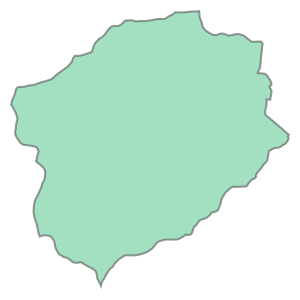

In [4]:
crs, watershed = workflow.get_split_form_shapes(watershed_shapefile)
logging.info(f'crs: {crs}')

bounds = watershed.exterior()
bounds

## Download Daymet

returned raw data has `dim(nband, ncol, nrow)`

In [5]:
startdate = "1-2020" # format "doy-YYYY"
enddate = "365-2020" # format "doy-YYYY"

In [6]:
# setting vars = None to download all available variables
raw, x, y = workflow.daymet.collectDaymet( bounds, start = startdate, end = enddate, 
                                          crs = crs, vars=None)

2021-08-30 18:25:24,286 - root - INFO: downloading variables: ['tmin', 'tmax', 'prcp', 'srad', 'vp', 'swe', 'dayl']
2021-08-30 18:25:24,370 - root - INFO: Collecting DayMet file to tile bounds: [-83.4885, 35.0173, -83.4117, 35.0838]
2021-08-30 18:25:24,372 - root - INFO:   Using existing: /home/ats_sc_user/short-course/02_model_setup/data/meteorology/daymet/daymet_tmin_2020_35.0838x-83.4885_35.0173x-83.4117.nc
2021-08-30 18:25:24,465 - root - INFO: Collecting DayMet file to tile bounds: [-83.4885, 35.0173, -83.4117, 35.0838]
2021-08-30 18:25:24,466 - root - INFO:   Using existing: /home/ats_sc_user/short-course/02_model_setup/data/meteorology/daymet/daymet_tmax_2020_35.0838x-83.4885_35.0173x-83.4117.nc
2021-08-30 18:25:24,554 - root - INFO: Collecting DayMet file to tile bounds: [-83.4885, 35.0173, -83.4117, 35.0838]
2021-08-30 18:25:24,556 - root - INFO:   Using existing: /home/ats_sc_user/short-course/02_model_setup/data/meteorology/daymet/daymet_prcp_2020_35.0838x-83.4885_35.0173x-8

## Reproject Daymet CRS (optional)

Reproject daymet CRS to the same as the watershed. This is necessary if watershed meshes are using watershed CRS that is different from Daymet CRS.

In [7]:
new_x, new_y, new_extent, new_dat, daymet_profile = workflow.daymet.reproj_Daymet(x, y, raw,  dst_crs = crs)

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:1216: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
2021-08-30 18:25:25,065 - root - INFO: reprojecting to new crs: +init=epsg:26917 +type=crs
2021-08-30 18:25:25,405 - root - INFO: new profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 9, 'height': 9, 'count': 365, 'crs': CRS.from_epsg(26917), 'transform': Affine(1269.247147171576, 0.0, 270906.5914069802,
       0.0, -1269.247147171576, 3886667.3291073246), 'tiled': False, 'interleave': 'pixel'}
2021-08-30 18:25:25,406 - root - INFO: new extent[xmin, ymin, xmax, ymax]: (270906.5914069802, 3875244.1047827806, 282329.8157315244, 3886667.3291073246)


## plot Daymet

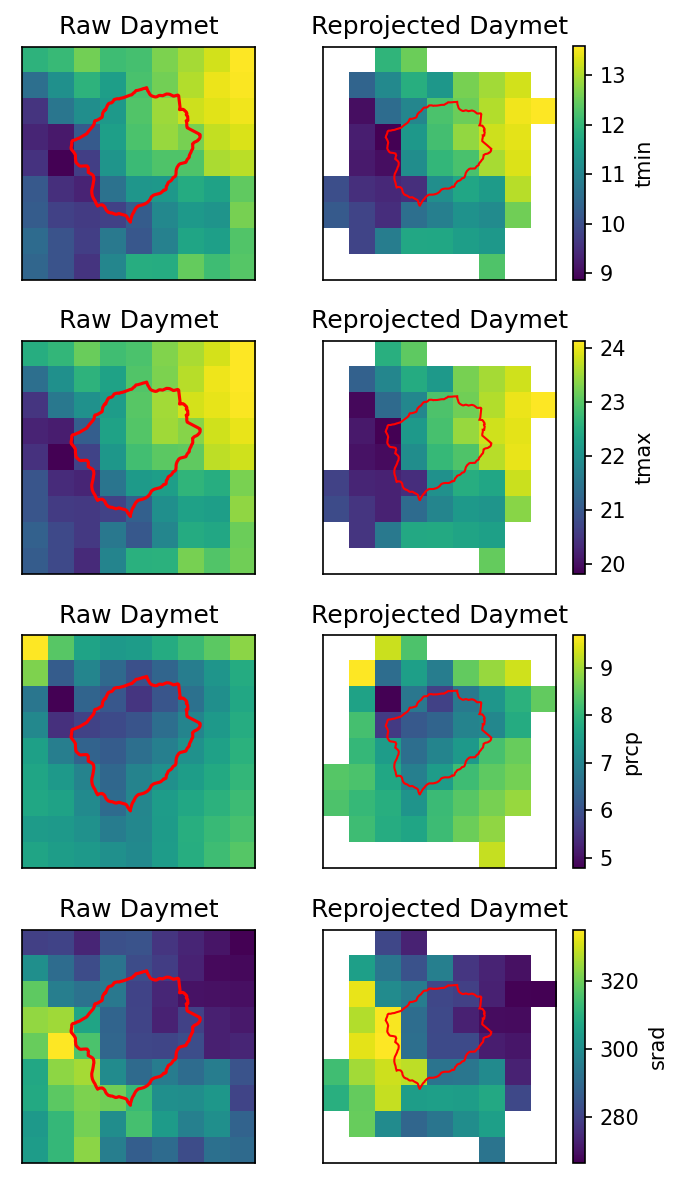

In [8]:
variables = ['tmin', 'tmax', 'prcp', 'srad']
# ivar = 'tmax'
islice = 125
fig, axes = plt.subplots(4, 2, figsize = (5, 8))


with fiona.open(watershed_shapefile, mode='r') as fid:
    bnd_profile = fid.profile
    bnd = [r for (i,r) in fid.items()]
daymet_crs = workflow.crs.daymet_crs()
# convert to destination crs
native_crs = workflow.crs.from_fiona(bnd_profile['crs'])
reproj_bnd = workflow.warp.shape(bnd[0], native_crs, daymet_crs)
reproj_bnd_shply = workflow.utils.shply(reproj_bnd)

for i,ivar in zip(range(4),variables):
    
    ax = axes[i, 0]
    iraster = raw[ivar][islice, :, :]
    extent = rasterio.transform.array_bounds(daymet_profile['height'], daymet_profile['width'], daymet_profile['transform']) # (x0, y0, x1, y1)
    plot_extent = extent[0], extent[2], extent[1], extent[3]
    
    ax.matshow(iraster, extent=plot_extent, alpha=1)
    ax.plot(*reproj_bnd_shply.exterior.xy, 'r')
    ax.set_title("Raw Daymet")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = axes[i, 1]
    iraster = new_dat[ivar][islice, :, :]
    extent = new_extent # (x0, y0, x1, y1)
    plot_extent = extent[0], extent[2], extent[1], extent[3] # (x0, x1, y0, y1)

    # set nodata to NaN to avoid plotting
    iraster[iraster == -9999] = np.nan
    workflow.plot.hucs(watershed, crs, ax=ax, color='r', linewidth=1)
    im = ax.matshow(iraster, extent=plot_extent)
    ax.set_title("Reprojected Daymet")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    cb = plt.colorbar(im, ax=ax)
    cb.ax.set_ylabel(ivar)
fig.tight_layout()

# save daymet

Save raw Daymet data to HDF5 file

In [9]:
workflow.daymet.writeHDF5(raw, x, y, 
                         workflow.daymet.getAttrs(bounds.bounds, startdate, enddate), 
                         'coweeta_daymet-raw.h5')

2021-08-30 18:25:26,180 - root - INFO: Writing HDF5 file: coweeta_daymet-raw.h5


## Write to ATS format

This will write daymet in a format that ATS can read. E.g., this will partition precipitation into rain and snow, convert vapor pressure to relative humidity, get mean air temperature and so on.

- dout has dims of `(ntime, nrow, ncol)` or `(ntime, ny, nx)`

- input XML file showing how Daymet is used in the model

```
      <ParameterList name="surface-air_temperature" type="ParameterList">
        <Parameter name="field evaluator type" type="string" value="independent variable" />
        <ParameterList name="function" type="ParameterList">
          <ParameterList name="domain" type="ParameterList">
            <Parameter name="region" type="string" value="surface domain" />
            <Parameter name="component" type="string" value="cell" />
            <ParameterList name="function" type="ParameterList">
              <ParameterList name="function-bilinear-and-time" type="ParameterList">
                <Parameter name="file" type="string" value="../data/coweeta_daymet-ats.h5" />
                <Parameter name="row header" type="string" value="y [m]" />
                <Parameter name="column header" type="string" value="x [m]" />
                <Parameter name="row coordinate" type="string" value="y" />
                <Parameter name="column coordinate" type="string" value="x" />
                <Parameter name="time header" type="string" value="time [s]" />
                <Parameter name="value header" type="string" value="air temperature [K]" />
              </ParameterList>
            </ParameterList>
          </ParameterList>
        </ParameterList>
      </ParameterList>

```

In [10]:
workflow.daymet.writeATS(raw, x, y, 
                         workflow.daymet.getAttrs(bounds.bounds, startdate, enddate), 
                         'coweeta_daymet-ats.h5')

2021-08-30 18:25:28,523 - root - INFO: Writing ATS file: coweeta_daymet-ats.h5
2021-08-30 18:25:28,527 - root - INFO: input dat shape: (365, 9, 9)
2021-08-30 18:25:28,528 - root - INFO: Converting to ATS met input


(array([       0.,    86400.,   172800.,   259200.,   345600.,   432000.,
          518400.,   604800.,   691200.,   777600.,   864000.,   950400.,
         1036800.,  1123200.,  1209600.,  1296000.,  1382400.,  1468800.,
         1555200.,  1641600.,  1728000.,  1814400.,  1900800.,  1987200.,
         2073600.,  2160000.,  2246400.,  2332800.,  2419200.,  2505600.,
         2592000.,  2678400.,  2764800.,  2851200.,  2937600.,  3024000.,
         3110400.,  3196800.,  3283200.,  3369600.,  3456000.,  3542400.,
         3628800.,  3715200.,  3801600.,  3888000.,  3974400.,  4060800.,
         4147200.,  4233600.,  4320000.,  4406400.,  4492800.,  4579200.,
         4665600.,  4752000.,  4838400.,  4924800.,  5011200.,  5097600.,
         5184000.,  5270400.,  5356800.,  5443200.,  5529600.,  5616000.,
         5702400.,  5788800.,  5875200.,  5961600.,  6048000.,  6134400.,
         6220800.,  6307200.,  6393600.,  6480000.,  6566400.,  6652800.,
         6739200.,  6825600.,  6912000